In [1]:
#imports and preprocessing, setting up train_loader
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Unsupervised-concept-centered-prototypical-parts/code

Mounted at /content/drive
/content/drive/MyDrive/Unsupervised-concept-centered-prototypical-parts/code


In [2]:
import torch
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

from dataset import utils
from dataset.cub2011 import Cub2011
from dataset.CombinedDataLoader import CDL

from models.classificationModel import ClassificationModel

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
    gpu_index = 0
else:
    device = torch.device('cpu')
    gpu_index = -1

  

print(device)



cuda


In [4]:


root = './dataset/data'



In [5]:
model = ClassificationModel(out_dim=1000, dataset='./dataset/data/CUB_200_2011')



/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 130MB/s]


In [6]:
model.backbone.fc = torch.nn.Sequential(#wariant 1
    torch.nn.Linear(in_features=512, out_features=128, bias=True),
    torch.nn.Linear(in_features=128, out_features=20, bias=True),
)

In [7]:

model.load_state_dict(torch.load('saved_models/test1.pth'))

<All keys matched successfully>

In [8]:
batch_size: int = 32

In [9]:


transformy = transforms.Compose([
    transforms.Resize((224, 224)), # Resize the image to 224x224
    transforms.ToTensor() # Convert the image to a tensor
])



In [10]:
#declare test_dataset and test_loader
test_loader1 = CDL(root, train=False, transform=transformy, num_classes=3, images=['cropped', "grayscale", "gaussianBlur", "colorJitter"])

In [11]:
test_loader = torch.utils.data.DataLoader(test_loader1, batch_size=32, shuffle=False, pin_memory=True, drop_last=True)

In [12]:
correct, numel = 0, 0
loss_fn = torch.nn.CrossEntropyLoss()
logs: dict = {
    "test_loss": [],
    "test_accuracy": []
}

for _ in range(10):
    with torch.no_grad():
        for x_test, y_test in test_loader:
            output = model(x_test)
            y_pred = torch.argmax(output, dim=1)
            correct += torch.sum(y_pred == y_test).item()
            numel += batch_size
            loss = loss_fn(output, y_test)
            logs['test_loss'].append(loss.item())
            logs['test_accuracy'].append(correct / numel)

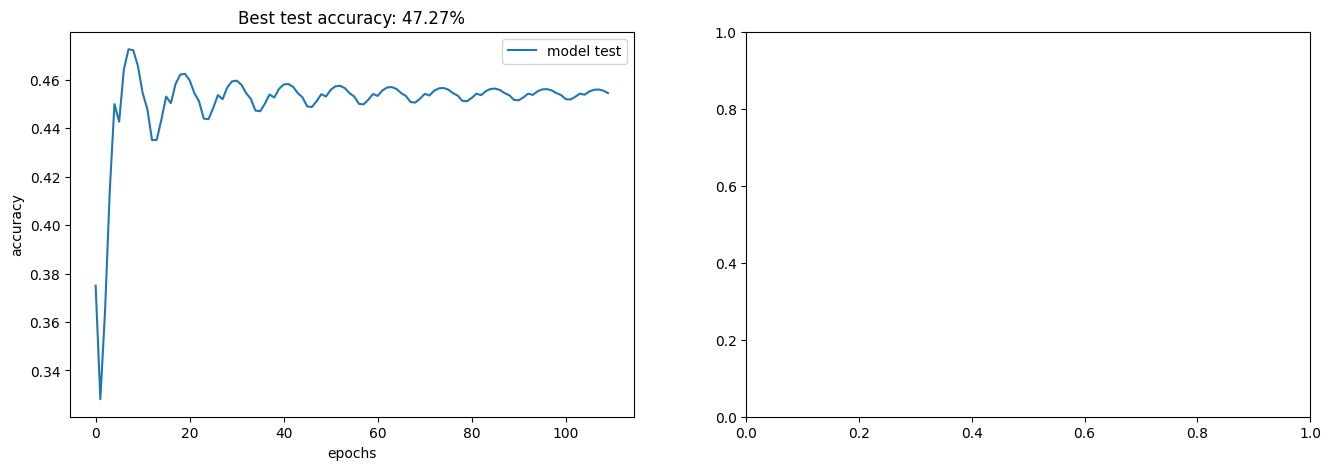

In [13]:


def show_results(orientation='horizontal', accuracy_bottom=None, loss_top=None, **histories):
    if orientation == 'horizontal':
        f, ax = plt.subplots(1, 2, figsize=(16, 5))
    else:
        f, ax = plt.subplots(2, 1, figsize=(16, 16))
    for i, (name, h) in enumerate(histories.items()):
        if len(histories) == 1:
            ax[0].set_title("Best test accuracy: {:.2f}%".format(
                max(h['test_accuracy']) * 100,
            ))
        else:
            ax[0].set_title("Accuracy")
        ax[0].plot(h['test_accuracy'], color='C%s' % i, label='%s test' % name)
        ax[0].set_xlabel('epochs')
        ax[0].set_ylabel('accuracy')
        if accuracy_bottom:
            ax[0].set_ylim(bottom=accuracy_bottom)
        ax[0].legend()

show_results(model=logs)